<ipython-input-4-0579918f8e4f>:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range("2025-02-01", periods=n_minutes, freq="T")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

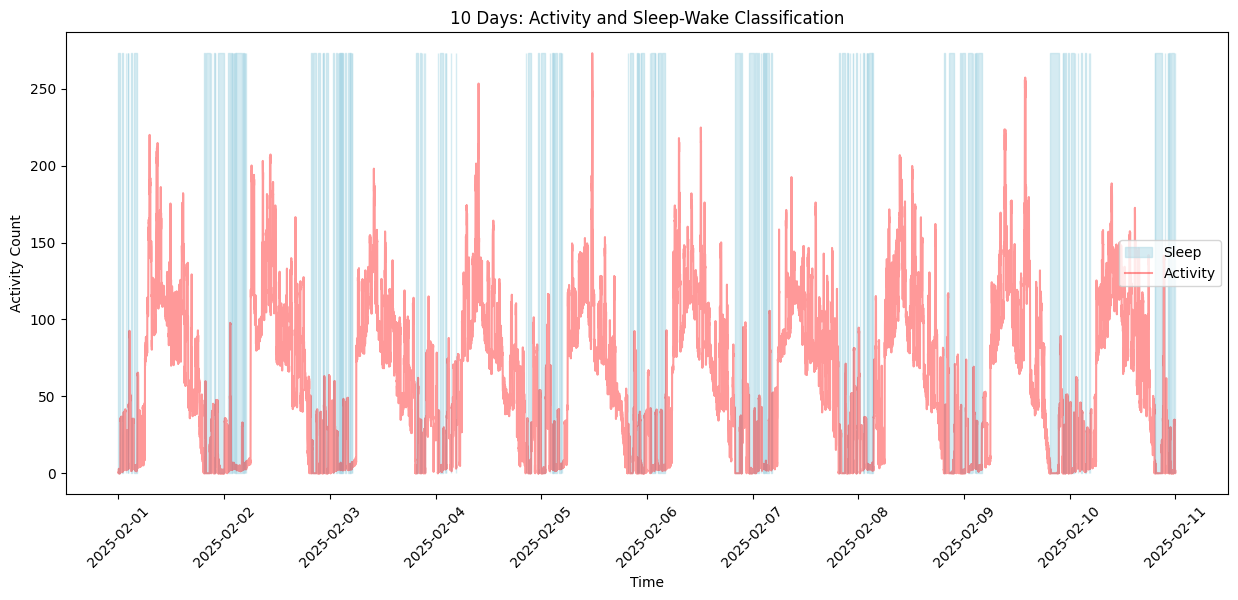

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

"""

Cole, R. J., Kripke, D. F., Gruen, W., Mullaney, D. J., & Gillin, J. C. (1992).
Automatic Sleep/Wake Identification From Wrist Activity. Sleep, 15(5), 461–469. http://doi.org/10.1093/sleep/15.5.461

Webster, J. B., Kripke, D. F., Messin, S., Mullaney, D. J., & Wyborney, G. (1982).
An Activity-Based Sleep Monitor System for Ambulatory Use. Sleep, 5(4), 389–399. https://doi.org/10.1093/sleep/5.4.389

"""

def generate_realistic_activity(n_days=10, sleep_start=23, sleep_end=6):  # Adjusted parameters

    """Generate more realistic actigraphy data for multiple days."""
    np.random.seed(42)
    n_minutes = n_days * 1440  # Total minutes for all days
    timestamps = pd.date_range("2025-02-01", periods=n_minutes, freq="T")

    # Varying baseline activity
    minutes_within_day = np.arange(n_minutes) % 1440  # Minute within each 24-hour cycle
    baseline_activity = 50 * (np.cos((minutes_within_day - 600) * (2 * np.pi / 1440)) + 1)  # Base cosine wave
    baseline_activity += 10 * np.sin((minutes_within_day - 900) * (2 * np.pi / (1440 / 3)))  # Add higher frequency component
    baseline_activity += 10 * np.sin((minutes_within_day - 300) * (2 * np.pi / (1440 / 6))) # Add lower frequency component

    # Sleep mask (using adjusted sleep_start and sleep_end)
    sleep_mask = ((minutes_within_day >= sleep_start * 60) | (minutes_within_day < sleep_end * 60))
    baseline_activity[sleep_mask] *= 0.1  # Reduce activity during sleep

    # Random bursts of activity
    burst_prob = 0.04  # Probability of a burst occurring each minute
    burst_duration = np.random.randint(5, 30, size=n_minutes)  # Duration of each burst in minutes
    burst_amplitude = np.random.randint(20, 50, size=n_minutes)  # Amplitude of each burst
    bursts = np.where(np.random.rand(n_minutes) < burst_prob, burst_amplitude, 0)
    for i in range(n_minutes):
        if bursts[i] > 0:
            end_burst = min(i + burst_duration[i], n_minutes)
            baseline_activity[i:end_burst] += bursts[i]

    # Restless sleep
    restless_prob = 0.01  # Probability of restless sleep each minute during sleep
    restless_amplitude = np.random.randint(1, 4, size=n_minutes)  # Amplitude of restless sleep
    restless_sleep = np.where(np.random.rand(n_minutes) < restless_prob, restless_amplitude, 0)
    baseline_activity[sleep_mask] += restless_sleep[sleep_mask]

    # Adjusted noise
    noise = np.random.normal(0, 4, size=n_minutes)  # Reduced noise amplitude
    noise[sleep_mask] = np.random.normal(0, 1, size=sleep_mask.sum())  # Minimal noise during sleep

    # Final activity counts
    activity_counts = np.clip(baseline_activity + noise, 0, None)

    return pd.DataFrame({"Timestamp": timestamps, "Activity": activity_counts})

def apply_cole_kripke(df):

    """Apply the Cole-Kripke algorithm to classify sleep/wake."""

    coefficients = np.array([1.06, 0.54, 0.58, 0.76, 2.30, 0.74, 0.67])
    activity_array = df["Activity"].to_numpy()
    sleep_scores = np.full(len(activity_array), np.nan)

    for i in range(4, len(activity_array) - 2):
        window = activity_array[i - 4:i + 3]  # Extract relevant window
        sleep_scores[i] = 0.0033 * np.sum(window * coefficients)

    df["Sleep_Score"] = sleep_scores
    df["Sleep_Wake"] = np.where(df["Sleep_Score"] >= 0.1, "Wake", "Sleep")

    return apply_webster_rescoring(df)

def apply_webster_rescoring(df):

    """Apply Webster's rescoring rules to refine sleep/wake classification."""

    sleep_wake = df["Sleep_Wake"].values

    wake_count_4 = 0
    wake_count_10 = 0
    wake_count_15 = 0

    for i in range(len(sleep_wake)):
        if sleep_wake[i] == "Wake":
            wake_count_4 += 1
            wake_count_10 += 1
            wake_count_15 += 1
        else:
            # Applying rescoring rules for sleep classifications
            if wake_count_4 >= 4:
                sleep_wake[i] = "Wake"
            elif wake_count_10 >= 10 and i + 2 < len(sleep_wake):
                sleep_wake[i:i + 3] = ["Wake"] * 3
                i += 2  # Skip ahead to avoid redundant checks
            elif wake_count_15 >= 15 and i + 3 < len(sleep_wake):
                sleep_wake[i:i + 4] = ["Wake"] * 4
                i += 3

            # Reset wake counts after checking and applying rules
            wake_count_4 = 0
            wake_count_10 = 0
            wake_count_15 = 0

    df["Sleep_Wake"] = sleep_wake
    return df

# Generate and process actigraphy data
data = generate_realistic_activity(n_days=10)
data = apply_cole_kripke(data)

# Save the generated data including the Sleep_Wake column
data.to_csv("actigraphy_10_days.csv", index=False)

from google.colab import files
files.download("actigraphy_10_days.csv")



# Plot activity and sleep-wake state
data["Sleep_Wake_Binary"] = data["Sleep_Wake"].map({"Wake": 1, "Sleep": 0})
plt.figure(figsize=(15, 6))
plt.fill_between(data["Timestamp"], 0, data["Activity"].max(),
                 where=(data["Sleep_Wake_Binary"] == 0), color="lightblue", alpha=0.5, label="Sleep")
sns.lineplot(x="Timestamp", y="Activity", data=data, color="red", alpha=0.4, label="Activity")
plt.xlabel("Time")
plt.ylabel("Activity Count")
plt.title("10 Days: Activity and Sleep-Wake Classification")
plt.legend()
plt.xticks(rotation=45)
plt.show()
